In [53]:
%reset -f
import sys
sys.path.insert(0, '..')
from wavhandler import *
import matplotlib.pyplot as plt

In [54]:
plt.rcParams['figure.figsize'] = [14, 6]

In [55]:
data = Dataset('Wingbeats')

Species: all.
Read 279566 filenames in 1.14 seconds.


In [56]:
from wavhandler import *
import numpy as np
import sys
import math
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from utils_train import train_test_val_split, TrainConfiguration, train_generator, valid_generator,mosquito_data_split, train_model

np.random.seed(42)

splitting = 'random'
data_setting = 'stft'
model_setting = 'conv2d'
cnn2d = 'no'
flag = '_'

assert splitting in ['random','randomcv','custom'], "Wrong splitting method given."
assert data_setting in ['raw','stft'], "Wrong data settting given."
assert model_setting in ['wavenet','lstm','gru','LSTM','GRU','CONV1D','CONV2D','conv1d','conv2d']

data = Dataset('Wingbeats')
print(data.target_classes)

print(f'SPLITTING DATA {splitting}')
X_train, X_val, X_test, y_train, y_val, y_test = mosquito_data_split(splitting=splitting, data=data)

['Ae. aegypti', 'Ae. albopictus', 'An. arabiensis', 'An. gambiae', 'C. pipiens', 'C. quinquefasciatus']
SPLITTING DATA random
Species: Ae. aegypti.
Read 85553 filenames in 2.32 seconds.
Species: Ae. albopictus.
Read 20231 filenames in 2.25 seconds.
Species: An. arabiensis.
Read 19297 filenames in 2.25 seconds.
Species: An. gambiae.
Read 49471 filenames in 2.24 seconds.
Species: C. pipiens.
Read 30415 filenames in 2.23 seconds.
Species: C. quinquefasciatus.
Read 74599 filenames in 2.26 seconds.


In [57]:
from wavhandler import make_df_parallel
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from utils_train import *
obj = create_settings_obj('stft')

In [58]:
datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)
train_matrix = make_df_parallel(names=X_train, setting='stft').values

In [59]:
shape = (len(X_train),129,120,1)
datagen.fit(train_matrix.reshape(shape))
train_mean = datagen.mean

In [60]:
train_mean

array([[[-44.406097]]], dtype=float32)

In [61]:
np.mean(train_matrix.reshape(shape), axis=(0, 1, 2))

array([-44.406097], dtype=float32)

In [62]:
train_matrix.mean(axis=1).mean()

-44.4058

In [69]:
from collections import OrderedDict

test = OrderedDict()
test.mean = np.mean(train_matrix, axis=(0,1))


In [67]:
test = {"mean":np.mean(train_matrix, axis=(0,1))}

test['mean']

-44.406097

In [73]:
test.mean.squeeze()

-44.406097

In [29]:
train_matrix.mean(axis=0).mean()

-44.405796

In [27]:
datagen.mean

array([[[-44.406097]]], dtype=float32)

# SPECTROGRAM PREPROCESSING

/home/kalfasyan/miniconda3/envs/wbtf2/lib/python3.6/site-packages/ipykernel_launcher.py:2: ComplexWarning: Casting complex values to real discards the imaginary part
  


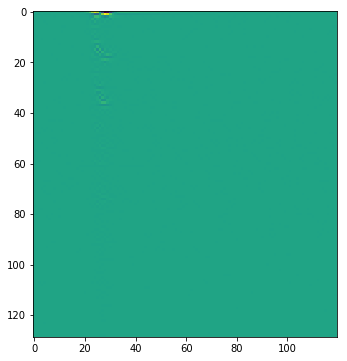

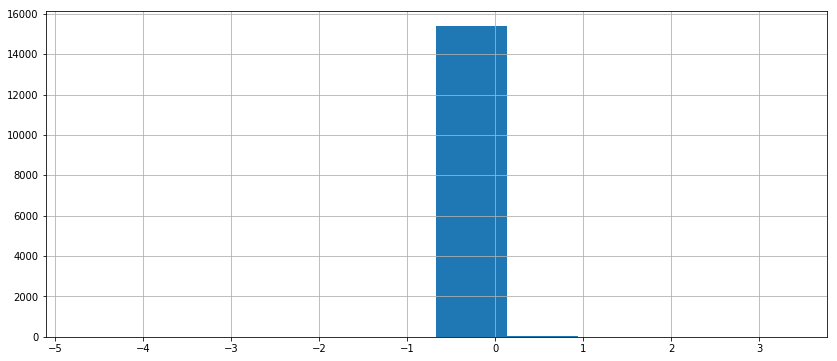

In [98]:
sig, _ = librosa.load(X_train[0], sr = SR)
sig = librosa.stft(sig, n_fft = N_FFT, hop_length = HOP_LEN).astype(float)
# sig = metamorphose(sig, setting='stft', stg_obj=obj)

plt.imshow(sig)
plt.figure()
pd.Series(sig.flatten()).hist()

In [124]:
sig_gauss

array([1817.0852 , 1684.9144 , 1193.044  , ...,  815.9761 ,  617.24054,
        562.3724 ], dtype=float32)

/home/kalfasyan/miniconda3/envs/wbtf2/lib/python3.6/site-packages/ipykernel_launcher.py:2: ComplexWarning: Casting complex values to real discards the imaginary part
  


0.027207128256493462

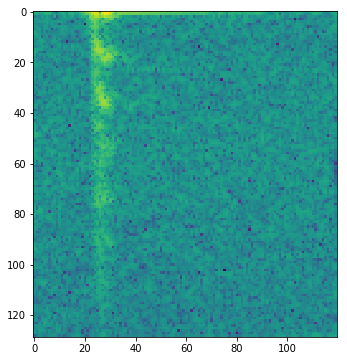

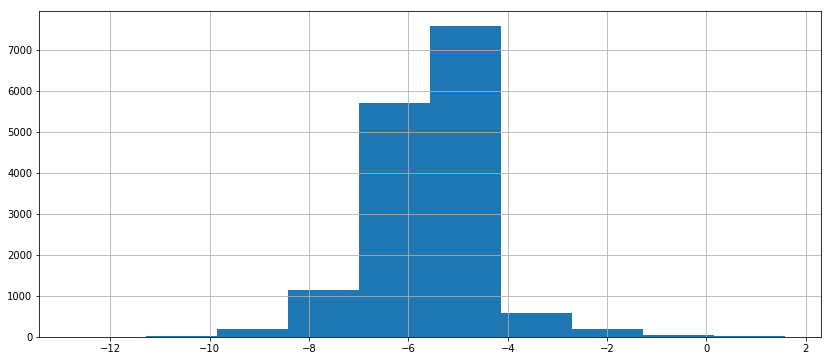

In [144]:
sig, _ = librosa.load(X_train[0], sr = SR)
sig = librosa.stft(sig, n_fft = N_FFT, hop_length = HOP_LEN).astype(float)

sig_gauss, l1 = boxcox(np.abs(sig).flatten())
sig_gauss_centered = (sig_gauss.reshape((129,120)) - train_mean.squeeze()) #/ datagen.std.squeeze()

plt.imshow(sig_gauss.reshape((129,120)))
plt.figure()
pd.Series(sig_gauss).hist()
# pd.Series(sig_gauss).var()
l1

In [142]:
(sig_gauss.reshape((129,120)) - train_mean.squeeze()) /datagen.std.squeeze()

array([[3.78598583, 3.77730309, 3.75823916, ..., 3.66869969, 3.7248096 ,
        3.74200811],
       [3.74125825, 3.72938031, 3.6816606 , ..., 3.57029031, 3.67836737,
        3.718545  ],
       [3.44912789, 3.60685233, 3.52837368, ..., 3.50723659, 3.60093661,
        3.68622266],
       ...,
       [3.66427255, 3.54520857, 3.65447234, ..., 3.45016481, 3.6046005 ,
        3.62184365],
       [3.63789863, 3.5509222 , 3.62170951, ..., 3.64002436, 3.6511466 ,
        3.61834996],
       [3.36263862, 3.48657302, 3.5803303 , ..., 3.68593595, 3.69270682,
        3.69640026]])

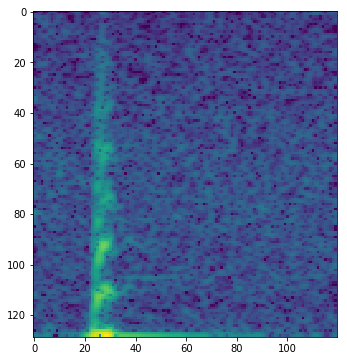

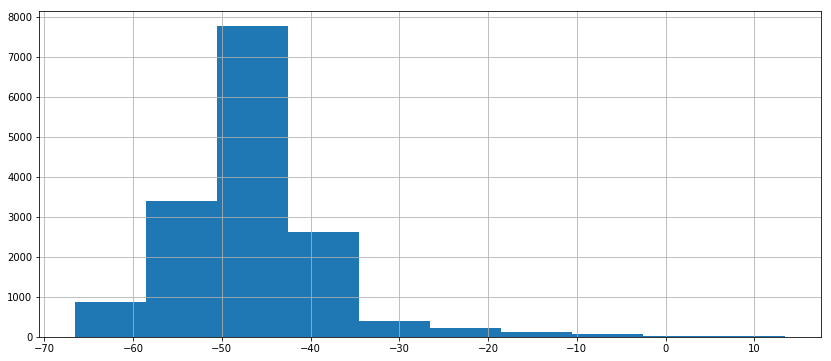

In [125]:
sig, _ = librosa.load(X_train[0], sr = SR)
sig_2d = metamorphose(sig, setting='stft', stg_obj=obj)

plt.imshow(sig_2d)
plt.figure(); pd.Series(sig_2d.flatten()).hist()

-2.9236717

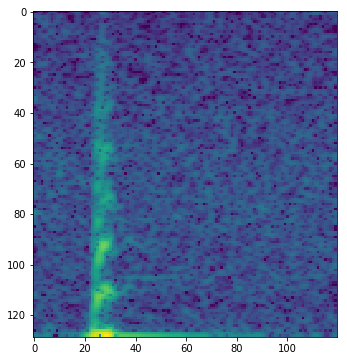

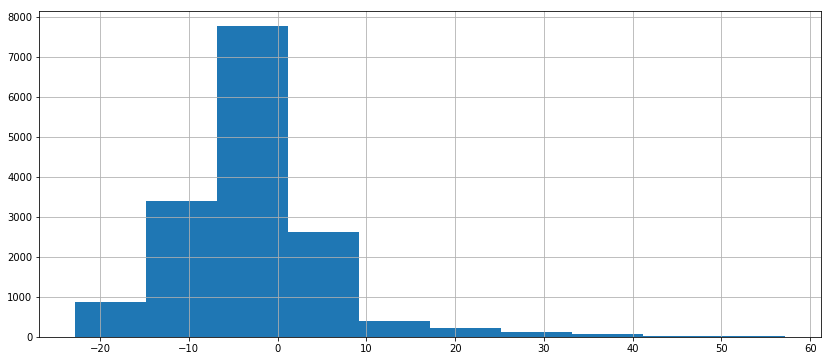

In [126]:
sig_centered = sig_2d - train_mean.squeeze()

plt.imshow(sig_centered)
plt.figure()
pd.Series(sig_centered.flatten()).hist()
pd.Series(sig_centered.flatten()).mean()

0.608355

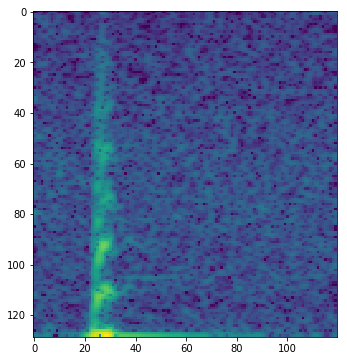

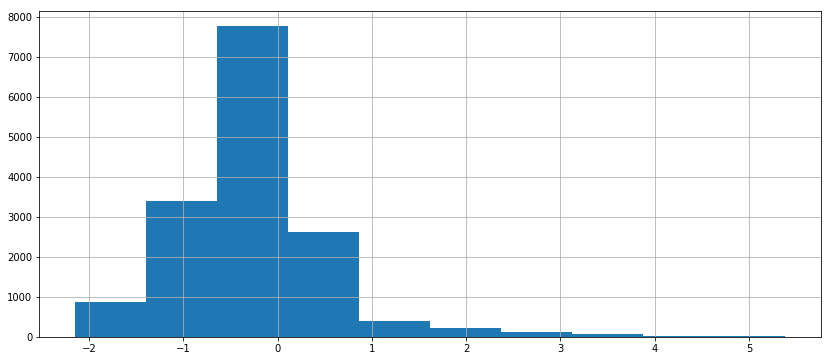

In [127]:
sig_standarized = sig_centered / datagen.std.squeeze()

plt.imshow(sig_standarized)
plt.figure()
pd.Series(sig_standarized.flatten()).hist()
pd.Series(sig_standarized.flatten()).var()

In [128]:
from scipy.stats import boxcox